In [4]:
import os
import sys
import h5py
import numpy as np
import pandas as pd

from scipy.fft import fft, fftfreq
from scipy.signal import sosfiltfilt
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from sklearn.preprocessing import StandardScaler
from scipy.integrate import cumtrapz
import math

plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Analyze Data

In [5]:
# a_vert.to_excel('a_vert.xlsx')
# max size 1048576, 16384 

In [6]:
def grab_data(path):
    # read in file 
    f = h5py.File(path, 'r')

    #create list of all journeys
    journey_list = list(f.keys())

    #creaty empty dfs
    a_vert= pd.DataFrame()
    a_lat= pd.DataFrame()
    a_long= pd.DataFrame()
    v= pd.DataFrame()
    data_len = []
    
    #go through all jounrey and grab IMU and ADC Data
    for jrn in journey_list:
        
        adc_data = f[jrn]['ADC2']['data_ADC2']

        #select ch0 = z_acc from ADC Data 
        df_adc = pd.DataFrame()
        
        for col in adc_data.dtype.names: 
            df_adc[col] = adc_data[col]         #here df for each journey gets stored -> this step necessary for handling h5 files . .
        
        a_vert[jrn] = df_adc['ch0']
        #a_lat[jrn] = df_adc['ch1']
        #a_long[jrn] = df_adc['ch2']
        v[jrn] = df_adc['speed']
    
    return a_vert, v

#a_vert, a_lat, a_long, v = grab_data(r"C:\Users\weil_tb\Local_Weiland/04_Daten/2020061711513200456/data_geo_2020061711513200456_20230210_153927.h5")
#a_vert.to_csv('a_vert.csv')
#v.to_csv('v.csv')
a_vert, v = grab_data(r"C:\Users\weil_tb\Local_Weiland/04_Daten/2020061711513200456/data_geo_2020061711513200456_20230210_153927.h5")

In [11]:
a_vert.journey_00.min()

-132.35432

Text(0.9, 0.5, 'Duration = 60.0s')

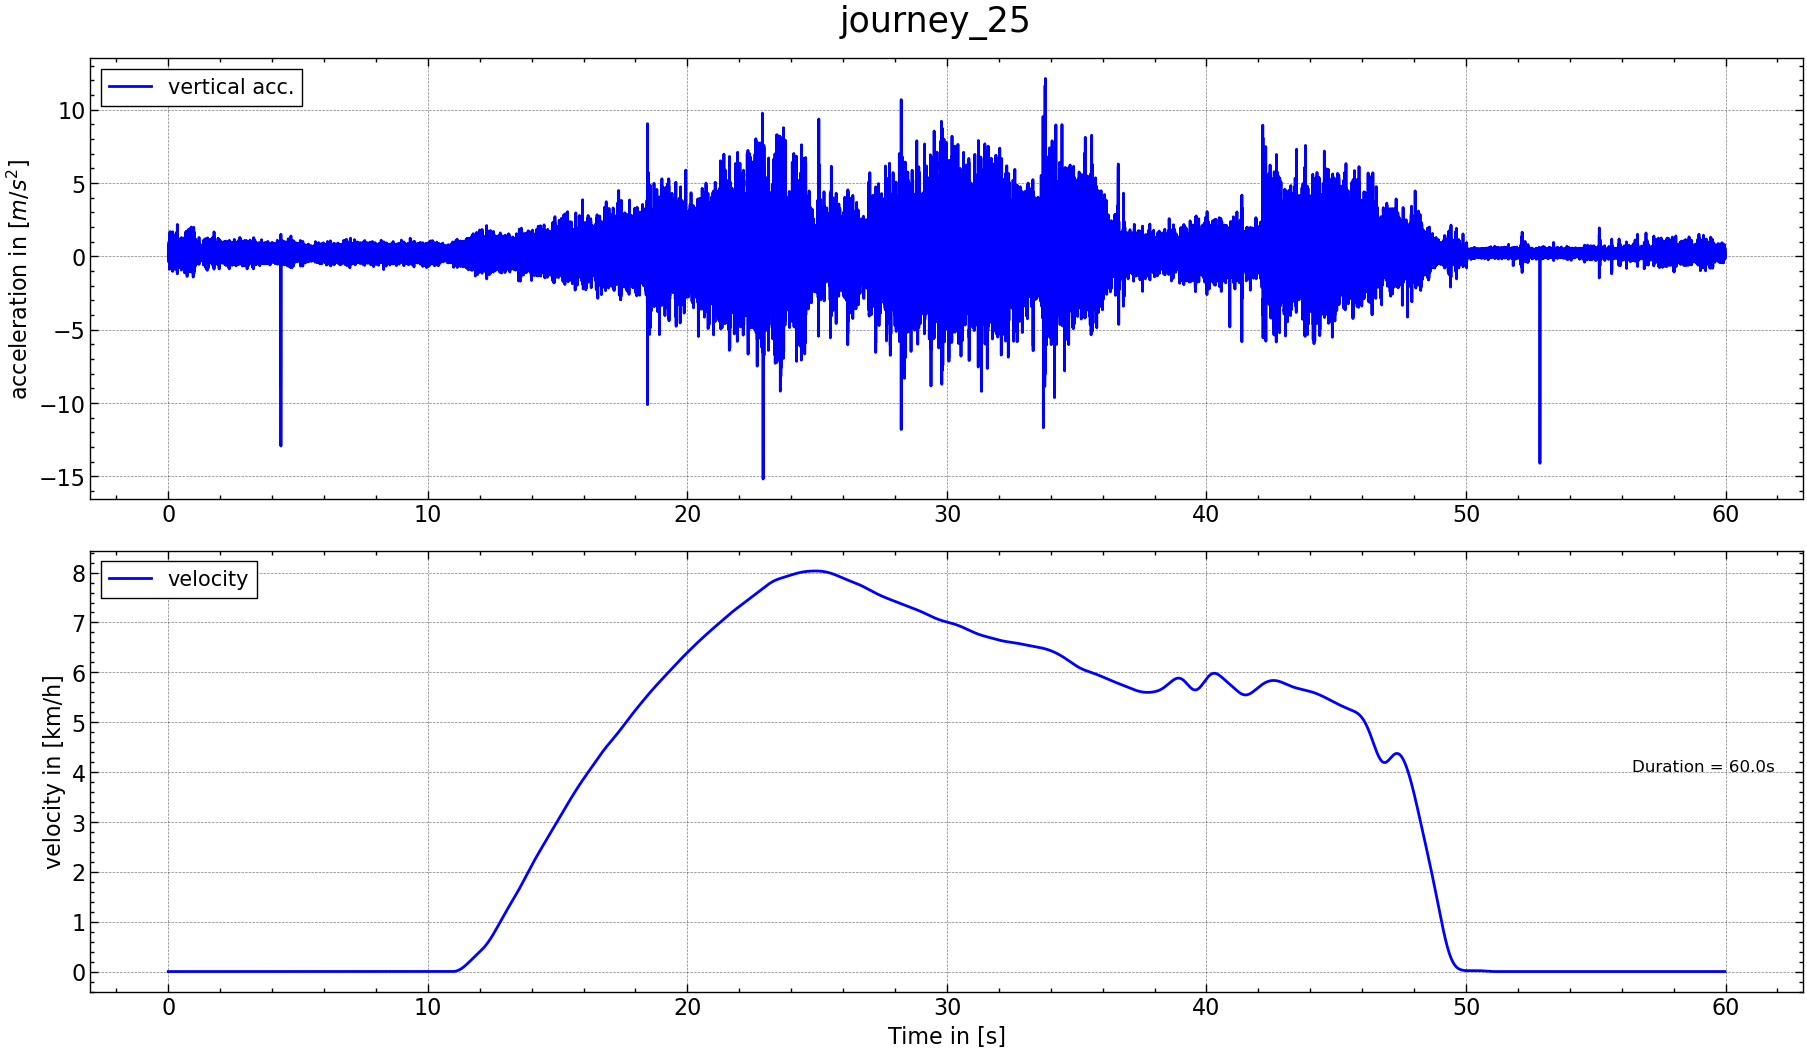

In [6]:
########################################## Just exchange journey's to create plot ####################################

#Create time vector
t = np.linspace(0,len(a_vert.journey_25)/20625, len(a_vert.journey_25)) # sampled in 20635 Hz

#Calc Length of Journey
nr_samples = a_vert.journey_25.isna().value_counts().iloc[1]
delta_t = 1/20625
len_jrn = nr_samples*delta_t

fig, axes = plt.subplots(2, 1, figsize=(18,10))
fig.tight_layout()
fig.suptitle('journey_25', y=1.03, fontsize=25)

ax = axes[0]
ax.grid('minor')
#ax.set_ylim(-100, 100) #  set limits to axes
ax.plot(t,a_vert.journey_25, label='vertical acc.', color='blue')
ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
ax.set_ylabel('acceleration in [$m/s^2$]')
#ax.text(0.925, 0.07, '-154.31384', transform=ax.transAxes,fontsize=12)
#ax.set_title('z-Acc Signal ADC')

# ax = axes[1]
# ax.grid('minor')
# #ax.set_ylim(-80, 80) #  set limits to axes
# ax.plot(t,a_long.journey_25, label='longitudinal acc.', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
# ax.set_ylabel('acceleration in [$m/s^2$]')
# #ax.text(0.93, 0.90, '180.64824', transform=ax.transAxes,fontsize=12)
# #ax.set_title('ADC spectrum (FFT) ')

# ax = axes[2]
# ax.grid('minor')
# #ax.set_ylim(-50, 50) #  set limits to axes
# ax.plot(t,a_lat.journey_25, label='lateral acc.', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
# ax.set_ylabel('acceleration in [$m/s^2$]')
# #ax.text(0.93, 0.90, '185.21605', transform=ax.transAxes,fontsize=12)
# #ax.set_title('ADC spectrum (FFT) ')

ax = axes[1]
ax.grid('minor')
ax.plot(t,v.journey_25*3.6, label='velocity', color='blue')
ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
ax.set_ylabel('velocity in [km/h]')
ax.set_xlabel('Time in [s]')
ax.text(0.9, 0.5, f'Duration = {round(len_jrn,1)}s', transform=ax.transAxes,fontsize=12)
#ax.set_title('z-Acc Signal IMU')

#plt.savefig('pictures/S0_journey_25.png', dpi=200)

Text(0, 0.5, 'Duration in [s]')

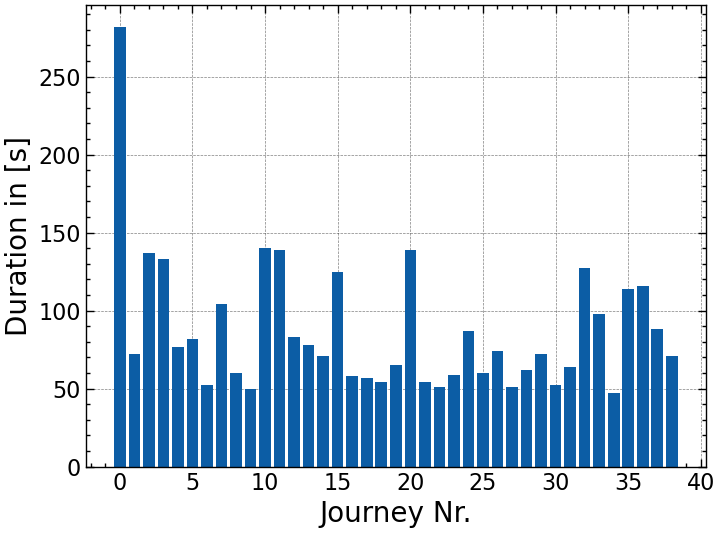

In [7]:
#Original Journey Length Distribution 
journey_list = a_vert.columns
length = []
for jrn in journey_list:
    if jrn != 'journey_00':
        x = a_vert[jrn].isna().value_counts().iloc[1]
    else: 
        x = len(a_vert[jrn])
    length.append(x*(1/20625))
    
x = np.linspace(0,38,39)
plt.bar(x,length)
plt.xlabel('Journey Nr.', fontsize=20)
plt.ylabel('Duration in [s]', fontsize=20)
#plt.savefig('pictures/Duration.png', dpi=200)

# Preprocessing 

## Bandpass Filter


In [8]:
# Apply Bandpass filter
from scipy.signal import butter, lfilter, sosfiltfilt
from scipy.signal import freqz


# define function for creating filter object
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high],output='sos',btype='band')
    return sos

# define function to apply created filter to data
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def filt_signal(signal, fs, lowcut, highcut):
    tot_len = signal.shape[0]
    #initiate empty DataFrame for filtered signal
    filtered_signal = pd.DataFrame()
    
    # Define Sample Rate and Cut-Off frequencies
    lowcut = 10
    highcut = 1000
    fs = 20625
    journey_list = signal.columns
    
    # go thorugh all journeys
    for jrn in journey_list:
        
            idx = (signal[jrn].isna() == False)
            x = signal[jrn].loc[idx].to_numpy()
            sample_len = len(x)
            padding_len = tot_len - sample_len
        
            #filter signal
            x_filt = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)

            #pad signal with NaNs
            pad = np.empty(padding_len)
            pad[:] = np.nan

            # add padding to filtered signal
            x_return =  np.concatenate((x_filt, pad), axis=0)
            
            # save in new DF
            filtered_signal[jrn] = x_return
            
    return filtered_signal

a_filt = filt_signal(a_vert, 20625, 10, 1000)
if a_vert.shape == a_filt.shape:
    print('Dim correct')
a_filt

Dim correct


,journey_00,journey_01,journey_02,journey_03,journey_04,journey_05,journey_06,journey_07,journey_08,journey_09,journey_10,journey_11,journey_12,journey_13,journey_14,journey_15,journey_16,journey_17,journey_18,journey_19,journey_20,journey_21,journey_22,journey_23,journey_24,journey_25,journey_26,journey_27,journey_28,journey_29,journey_30,journey_31,journey_32,journey_33,journey_34,journey_35,journey_36,journey_37,journey_38
0,-0.043962,-0.034867,0.061756,0.058477,0.011814,0.002641,-0.067774,0.018638,0.018457,-0.420920,-0.013864,-0.047724,-0.090816,0.003122,-0.084407,0.021025,0.050151,-0.009337,-0.164538,0.055557,0.020193,-0.126203,0.005512,-0.087368,-0.102644,0.127122,0.029661,-0.044522,0.008347,-0.121500,-0.339394,-0.100090,0.093685,0.027582,-0.075708,-0.047259,0.041768,0.062837,-0.053409
1,-0.056887,-0.059235,0.070199,0.049351,0.018180,0.006368,-0.068730,0.026063,0.025949,-0.491839,-0.002700,-0.047607,-0.110355,-0.001445,-0.095727,0.049875,0.065228,0.014185,-0.198854,0.081274,0.016579,-0.126955,-0.000824,-0.094640,-0.108373,0.162206,0.005513,-0.056124,0.001180,-0.139769,-0.309292,-0.110831,0.101678,0.017902,-0.083547,-0.050525,0.044961,0.058959,-0.052302
2,-0.069117,-0.083458,0.078255,0.040803,0.023869,0.009791,-0.069627,0.032797,0.033351,-0.561649,0.008132,-0.047531,-0.128159,-0.005804,-0.108533,0.077633,0.080074,0.036289,-0.233422,0.106507,0.012758,-0.128177,-0.006625,-0.101700,-0.113901,0.198014,-0.017902,-0.068103,-0.005045,-0.157935,-0.273922,-0.121629,0.109948,0.008922,-0.091173,-0.053766,0.047402,0.055845,-0.051363
3,-0.080225,-0.107501,0.085374,0.033373,0.028392,0.012760,-0.070389,0.038402,0.040548,-0.629250,0.018769,-0.047497,-0.143483,-0.009771,-0.123088,0.103267,0.094536,0.055892,-0.267772,0.131091,0.008477,-0.130021,-0.011398,-0.108689,-0.118987,0.235035,-0.039988,-0.080728,-0.009580,-0.175892,-0.229972,-0.132482,0.118848,0.001251,-0.098683,-0.057063,0.048324,0.054038,-0.050832
4,-0.090126,-0.131381,0.091088,0.027478,0.031510,0.015335,-0.070954,0.042690,0.047459,-0.693563,0.029724,-0.047467,-0.156547,-0.013267,-0.138018,0.125893,0.108601,0.072364,-0.300840,0.155152,0.003614,-0.132354,-0.014810,-0.115906,-0.123386,0.273145,-0.060298,-0.094291,-0.012057,-0.193460,-0.178045,-0.143280,0.128679,-0.004786,-0.106227,-0.060600,0.047206,0.053790,-0.050965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816315,-0.030716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5816316,-0.028787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5816317,-0.027124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5816318,-0.025642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


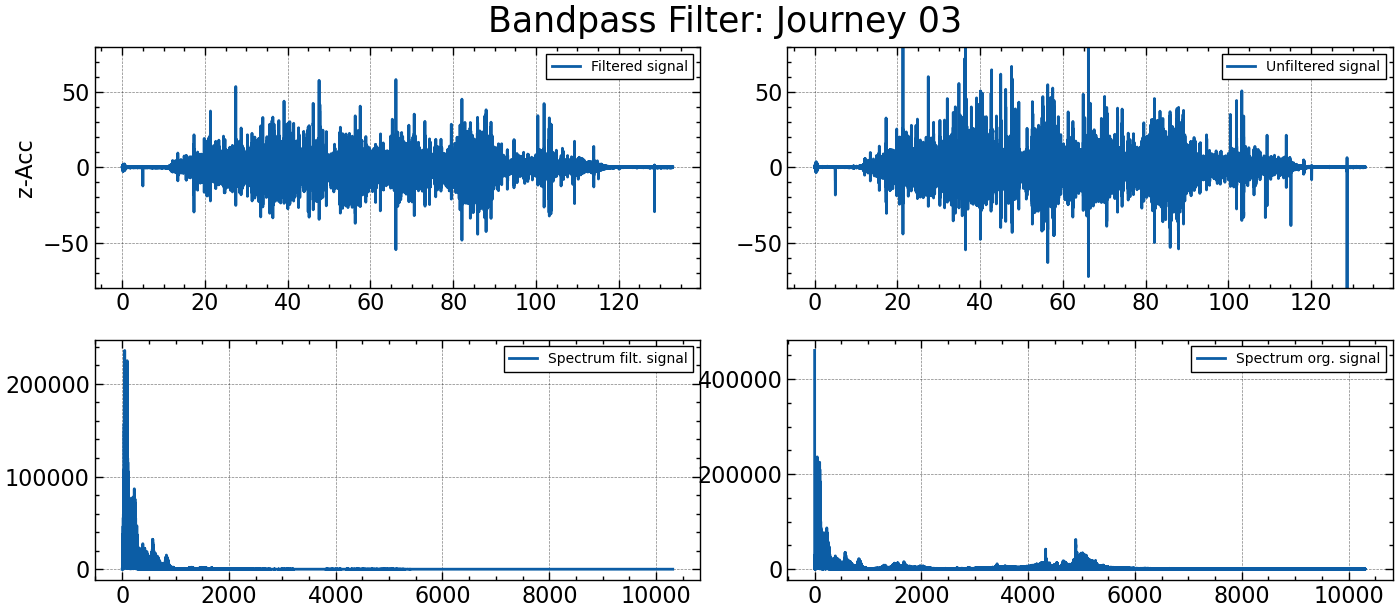

In [9]:
# FFT of original ajnd filtered signal
filt = (a_vert['journey_03'].isna() == False)
x = a_vert['journey_03'].loc[filt].to_numpy()
x_filt = a_filt['journey_03'].loc[filt].to_numpy()
N = len(x)
N_filt = len(x_filt)
x_spec = fft(x)[:N//2]
x_filt_spec = fft(x_filt)[:N_filt//2]

# Spectrum of FFTs
f = fftfreq(N, 1/20625)[:N//2]
f_filt = fftfreq(N_filt, 1/20625)[:N_filt//2]


fs = 20625.0
lowcut = 10
highcut = 1000
T = len(x)/20625
nsamples = len(x)
t = np.linspace(0, T, nsamples, endpoint=False)


#plot filtered and unfiltered signal
fig, axes = plt.subplots(2, 2, figsize=(14,6))
fig.tight_layout()
fig.suptitle('Bandpass Filter: Journey 03', y=1.03, fontsize=25)
ax = axes[0][0]
ax.plot(t,x_filt, label='Filtered signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
ax.set_ylabel('z-Acc')
ax.set_ylim(-80, 80) #  set limits to axes
ax = axes[0][1]
ax.plot(t,x, label='Unfiltered signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
ax.set_ylim(-80, 80) #  set limits to axes
ax = axes[1][0]
ax.plot(f, np.abs(x_filt_spec), label='Spectrum filt. signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
#ax.set_ylim(-10, 120) #  set limits to axes
ax = axes[1][1]
ax.plot(f_filt, np.abs(x_spec), label='Spectrum org. signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
#ax.set_ylim(-10, 120) #  set limits to axes
#plt.savefig('pictures/S0_journey_03_filt.png', dpi=200)

## Remove Mean

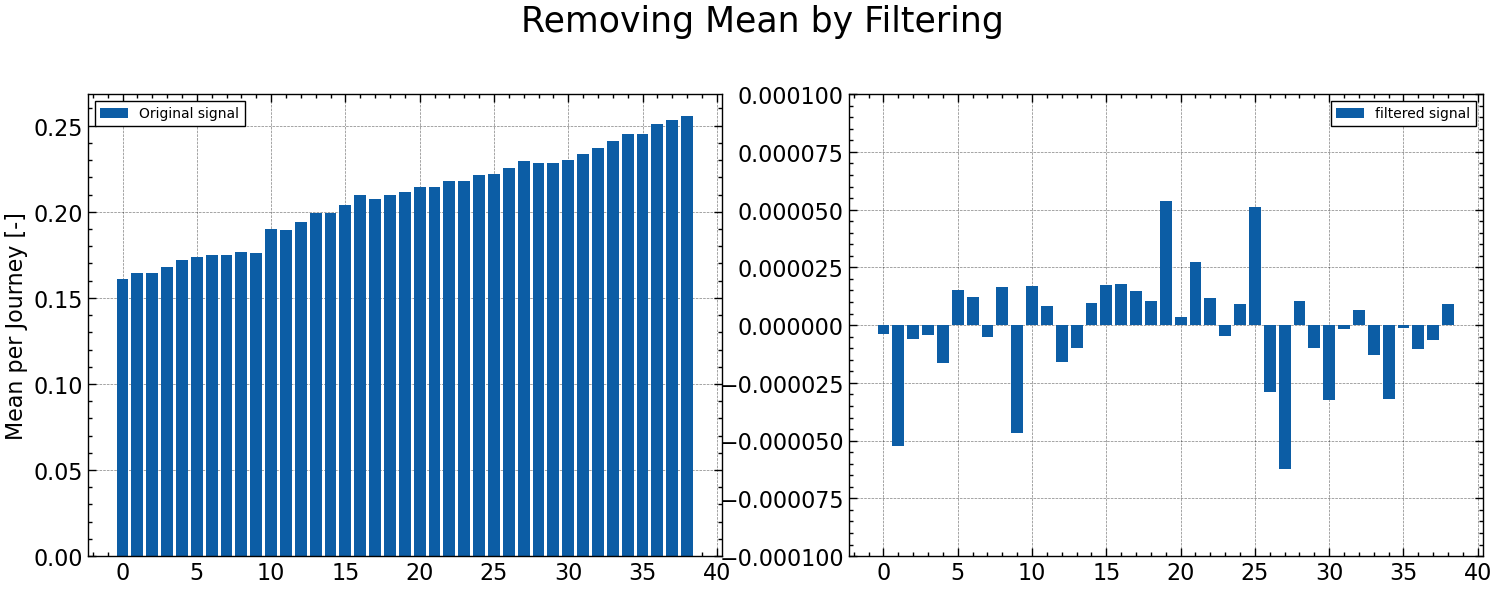

In [10]:
mean = []
mean_filt = []
journey_list = a_filt.columns
for jrn in journey_list:
    mean.append(a_vert[jrn].mean())
    mean_filt.append(a_filt[jrn].mean())

x = np.linspace(0,38,39)
fig, axes = plt.subplots(1, 2, figsize=(18,6))
#fig.tight_layout()
fig.suptitle('Removing Mean by Filtering', y=1.03, fontsize=25)
ax = axes[0]
ax.bar(x,mean, label='Original signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
ax.set_ylabel('Mean per Journey [-]')
ax = axes[1]
ax.bar(x,mean_filt, label='filtered signal')
ax.legend(fontsize=10, fancybox=False, edgecolor='black',loc=0)
ax.set_ylim(-0.0001, 0.0001) #  set limits to axes
plt.savefig('pictures/MEAN.png', dpi=200)

## Shorten Data

In [11]:
######################################Check why journey 11, 14 , etc. are full of NaNs!
def fnc_neg(old):
    return (-1*old)

def check_speed(a_vert, v):

    # Function deletes samples from vertical acc. data if speed is <1 m/s
    # input as pandas dfs

    a_vert_ = pd.DataFrame()
    v_ = pd.DataFrame()
    
    # check if dfs have same shape
    if a_vert.shape != v.shape:
        print('Error: Wrong dimensions!')
        exit()

    # create list which contains strings for each journey
    journey_list = a_vert.columns

    #loop going through all jounreys
    for jrn in journey_list:
        if v[jrn].max()== 0:
            v[jrn]=v[jrn].apply(fnc_neg)
        
        filt = (v[jrn] > 0.2)
        a_vert_[jrn] = a_vert[jrn].loc[filt]
        v_[jrn] = v[jrn].loc[filt]


    return a_vert_, v_

a_filt_,v_ = check_speed(a_filt, v)

In [11]:
a_filt_.reset_index(inplace=True)
v_.reset_index(inplace=True)
del a_filt_['index']
del v_['index']
a_filt_

,journey_00,journey_01,journey_02,journey_03,journey_04,journey_05,journey_06,journey_07,journey_08,journey_09,journey_10,journey_11,journey_12,journey_13,journey_14,journey_15,journey_16,journey_17,journey_18,journey_19,journey_20,journey_21,journey_22,journey_23,journey_24,journey_25,journey_26,journey_27,journey_28,journey_29,journey_30,journey_31,journey_32,journey_33,journey_34,journey_35,journey_36,journey_37,journey_38
0,-0.358629,0.314850,0.607652,0.736636,-0.086780,-0.063312,-0.037332,0.070541,0.010849,0.715345,0.032499,NaN,NaN,-0.421132,NaN,NaN,NaN,0.182164,0.137961,0.022301,-0.043301,0.024113,-0.039557,NaN,-0.111391,NaN,0.378438,0.300892,NaN,-0.283335,0.142578,0.030489,0.080772,0.118024,1.677624,0.134769,-1.318326,-0.925419,-0.097296
1,-0.370671,0.313389,0.648494,0.761373,-0.084730,-0.062541,-0.034009,0.089360,0.009970,0.693101,0.018690,NaN,NaN,-0.340580,NaN,NaN,NaN,0.194276,0.146813,0.021761,-0.043894,0.021001,-0.062761,NaN,-0.116602,NaN,0.376149,0.300350,NaN,-0.289580,0.138861,-0.018643,0.066807,0.150267,1.620408,0.157710,-1.007737,-0.982199,-0.113068
2,-0.379628,0.309208,0.686368,0.778904,-0.083149,-0.061331,-0.031062,0.109623,0.007582,0.667022,0.003518,NaN,NaN,-0.232843,NaN,NaN,NaN,0.206020,0.157135,0.023105,-0.042095,0.017608,-0.087016,NaN,-0.122350,NaN,0.373479,0.300786,NaN,-0.297238,0.135171,-0.070849,0.052690,0.182413,1.555854,0.180163,-0.734925,-1.040622,-0.129211
3,-0.385268,0.302171,0.720760,0.789000,-0.080754,-0.059675,-0.028612,0.131211,0.003929,0.637010,-0.013297,NaN,NaN,-0.145359,NaN,NaN,NaN,0.217380,0.169095,0.026027,-0.038172,0.013833,-0.112265,NaN,-0.128248,NaN,0.369993,0.302433,NaN,-0.305259,0.131765,-0.125364,0.038571,0.213640,1.486188,0.201805,-0.500914,-1.098536,-0.145435
4,-0.387332,0.292333,0.751367,0.791476,-0.076625,-0.057462,-0.026885,0.153872,-0.000597,0.601413,-0.032077,NaN,NaN,-0.091077,NaN,NaN,NaN,0.228240,0.182809,0.030662,-0.032573,0.009599,-0.138924,NaN,-0.133489,NaN,0.366151,0.305263,NaN,-0.312795,0.128702,-0.180683,0.024631,0.243110,1.413048,0.221995,-0.305499,-1.154644,-0.161448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5152499,0.076226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152500,0.076387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152501,0.075790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152502,0.074401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
invalid_values = [] # in seconds [s]
nans = 0
for jrn in journey_list:
    if a_filt_[jrn].isna().value_counts().shape == (1,):
        nans = 0
    else: 
        nans = a_filt_[jrn].isna().value_counts().iloc[0]
    invalid_values.append({nans/20625, jrn})

#invalid_values

In [13]:
# # Create time vector
# t = np.linspace(0,len(a_vert.journey_35)/20625, len(a_vert.journey_35)) # sampled in 20635 Hz
# t_ = np.linspace(0,len(a_vert_.journey_35)/20625, len(a_vert_.journey_35)) # sampled in 20635 Hz

# #Calc Length of Journey
# nr_samples = a_vert.journey_35.isna().value_counts().iloc[1]
# nr_samples_ = a_vert_.journey_35.isna().value_counts().iloc[1]
# delta_t = 1/20625
# len_jrn = nr_samples*delta_t
# len_jrn_ = nr_samples_*delta_t

# fig, axes = plt.subplots(2, 2, figsize=(18,10))
# fig.tight_layout()
# fig.suptitle('Shorten Data (Threshold = 0.2 m/s)', y=1.03, fontsize=25)

# ax = axes[0][0]
# ax.grid('minor')
# #ax.set_ylim(-100, 100) #  set limits to axes
# ax.plot(t,a_vert.journey_35, label='vertical acc.', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
# ax.set_ylabel('acceleration in [$m/s^2$]')
# #ax.text(0.925, 0.07, '-154.31384', transform=ax.transAxes,fontsize=12)
# #ax.set_title('z-Acc Signal ADC')

# ax = axes[0][1]
# ax.grid('minor')
# #ax.set_ylim(-80, 80) #  set limits to axes
# ax.plot(t_,a_vert_.journey_35, label='vertical acc. (shortened)', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')


# ax = axes[1][0]
# ax.grid('minor')
# #ax.set_ylim(-50, 50) #  set limits to axes
# ax.plot(t,v.journey_35, label='velocity', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
# ax.set_ylabel('velocity in [km/h]')
# #ax.text(0.9, 0.5, f'Duration = {round(len_jrn,1)}s', transform=ax.transAxes,fontsize=12)
# ax.set_xlabel('Time in [s]')

# ax = axes[1][1]
# ax.grid('minor')
# ax.plot(t_,v_.journey_35*3.6, label='velocity (shortened)', color='blue')
# ax.legend(fontsize=15, fancybox=False, edgecolor='black',loc='upper left')
# ax.set_xlabel('Time in [s]')

# #plt.savefig('pictures/shorten_data.png', dpi=200)

In [14]:
print(v.shape)
print(v_.shape)

(5816320, 39)
(5152504, 39)


Text(0, 0.5, 'Duration in [s]')

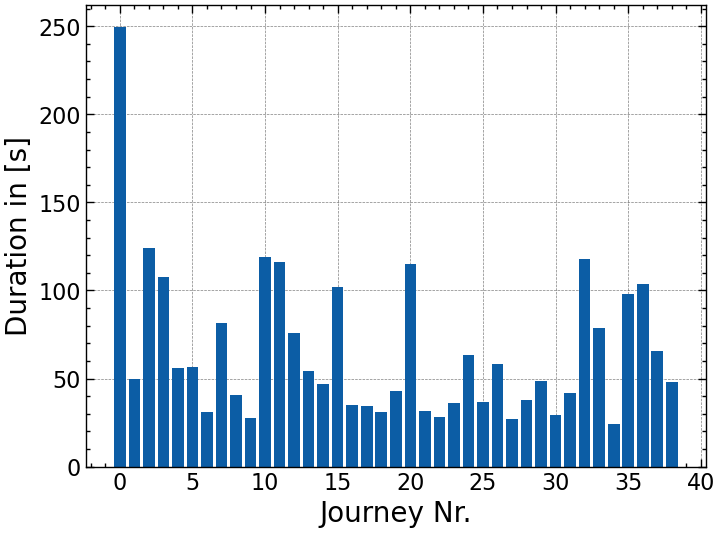

In [15]:
journey_list = a_filt_.columns
length = []
for jrn in journey_list:
    if a_filt_[jrn].isna().value_counts().shape == (1,):
        x = len(a_filt_[jrn])
    else: 
        x = a_filt_[jrn].isna().value_counts().iloc[1]
    length.append(x*(1/20625))
    
x = np.linspace(0,len(journey_list)-1,len(journey_list))
plt.bar(x,length)
plt.xlabel('Journey Nr.', fontsize=20)
plt.ylabel('Duration in [s]', fontsize=20)
#plt.savefig('pictures/Duration_shortened.png', dpi=200)

In [17]:
a_filt_.to_csv('a_filt_.csv')

# Rearrange Samples

In [100]:
a_vert_

,journey_00,journey_01,journey_02,journey_03,journey_04,journey_05,journey_06,journey_07,journey_08,journey_09,journey_10,journey_11,journey_12,journey_13,journey_14,journey_15,journey_16,journey_17,journey_18,journey_19,journey_20,journey_21,journey_22,journey_23,journey_24,journey_25,journey_26,journey_27,journey_28,journey_29,journey_30,journey_31,journey_32,journey_33,journey_34,journey_35,journey_36,journey_37,journey_38
0,-0.358629,0.314850,0.607652,0.736636,-0.086780,-0.063312,-0.037332,0.070541,0.010849,0.715345,0.032499,NaN,NaN,-0.421132,NaN,NaN,NaN,0.182164,0.137961,0.022301,-0.043301,0.024113,-0.039557,NaN,-0.111391,NaN,0.378438,0.300892,NaN,-0.283335,0.142578,0.030489,0.080772,0.118024,1.677624,0.134769,-1.318326,-0.925419,-0.097296
1,-0.370671,0.313389,0.648494,0.761373,-0.084730,-0.062541,-0.034009,0.089360,0.009970,0.693101,0.018690,NaN,NaN,-0.340580,NaN,NaN,NaN,0.194276,0.146813,0.021761,-0.043894,0.021001,-0.062761,NaN,-0.116602,NaN,0.376149,0.300350,NaN,-0.289580,0.138861,-0.018643,0.066807,0.150267,1.620408,0.157710,-1.007737,-0.982199,-0.113068
2,-0.379628,0.309208,0.686368,0.778904,-0.083149,-0.061331,-0.031062,0.109623,0.007582,0.667022,0.003518,NaN,NaN,-0.232843,NaN,NaN,NaN,0.206020,0.157135,0.023105,-0.042095,0.017608,-0.087016,NaN,-0.122350,NaN,0.373479,0.300786,NaN,-0.297238,0.135171,-0.070849,0.052690,0.182413,1.555854,0.180163,-0.734925,-1.040622,-0.129211
3,-0.385268,0.302171,0.720760,0.789000,-0.080754,-0.059675,-0.028612,0.131211,0.003929,0.637010,-0.013297,NaN,NaN,-0.145359,NaN,NaN,NaN,0.217380,0.169095,0.026027,-0.038172,0.013833,-0.112265,NaN,-0.128248,NaN,0.369993,0.302433,NaN,-0.305259,0.131765,-0.125364,0.038571,0.213640,1.486188,0.201805,-0.500914,-1.098536,-0.145435
4,-0.387332,0.292333,0.751367,0.791476,-0.076625,-0.057462,-0.026885,0.153872,-0.000597,0.601413,-0.032077,NaN,NaN,-0.091077,NaN,NaN,NaN,0.228240,0.182809,0.030662,-0.032573,0.009599,-0.138924,NaN,-0.133489,NaN,0.366151,0.305263,NaN,-0.312795,0.128702,-0.180683,0.024631,0.243110,1.413048,0.221995,-0.305499,-1.154644,-0.161448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5152499,0.076226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152500,0.076387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152501,0.075790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5152502,0.074401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# some calculations
# shortest sample in session in [s]
print(min(length))
print(24*20625)
print(max(length)/min(length))

24.057406060606063
495000
10.384260677490609


In [102]:
# Problemsolving #######################################################
# samples = 500
# batches = 50
# a_test = a_vert_.iloc[0:500]
# aa = pd.DataFrame()
# aa['1_1'] = a_test.iloc[0:49, 1]#.to_numpy()
# aa['1_2'] = a_test.iloc[50:99, 1]#.to_numpy()
# #pd.concat([a_test.iloc[0:49, 1],a_test.iloc[50:99, 1]], axis=1, ignore_index=True)

#a_vert_.loc[[0*495000,(0+1)*495000],'journey_00']
# test = pd.DataFrame()
# test['1'] = a_vert_.loc[range(459),'journey_01'].copy()
# test

# min_samples = 500
# i=2
# idx = np.linspace(i*min_samples, (i+1)*min_samples-1, min_samples)
# idx
# test = a_vert_.loc[idx,'journey_01'].copy().tonumpy()
# test

In [103]:
# import warnings
# warnings.filterwarnings('ignore')
def rearrange_samples(a,min_samples):
    journey_list = a.columns  
    
    #empty DF
    X = pd.DataFrame()
    loss = 0
    # go through all journeys
    for jrn in journey_list:
        if a_vert_[jrn].isna().value_counts().shape == (1,):
            valid_samples = len(a_vert_[jrn])
        else: 
            valid_samples = a_vert_[jrn].isna().value_counts().iloc[1]

        # use floor so only full samples are produced
        times = math.floor(valid_samples/min_samples)
        loss = loss + (valid_samples/min_samples-times)*min_samples
        
        if times == 1:
            X[jrn] = a.loc[range(min_samples),jrn].copy()
        else:
            for i in range(times-1):
                string = jrn + '_' + str(i)
                idx = np.linspace(i*min_samples, (i+1)*min_samples-1, min_samples)
                #X[string] = a[jrn][(i*min_samples):((i+1)*min_samples)]
                X[string] = a.loc[idx,jrn].to_numpy()
    return X, loss

X, loss = rearrange_samples(a_vert_,495000)
X

,journey_00_0,journey_00_1,journey_00_2,journey_00_3,journey_00_4,journey_00_5,journey_00_6,journey_00_7,journey_00_8,journey_01_0,journey_02_0,journey_02_1,journey_02_2,journey_02_3,journey_03_0,journey_03_1,journey_03_2,journey_04_0,journey_05_0,journey_06,journey_07_0,journey_07_1,journey_08,journey_09,journey_10_0,journey_10_1,journey_10_2,journey_11_0,journey_11_1,journey_11_2,journey_12_0,journey_12_1,journey_13_0,journey_14,journey_15_0,journey_15_1,journey_15_2,journey_16,journey_17,journey_18,journey_19,journey_20_0,journey_20_1,journey_20_2,journey_21,journey_22,journey_23,journey_24_0,journey_25,journey_26_0,journey_27,journey_28,journey_29_0,journey_30,journey_31,journey_32_0,journey_32_1,journey_32_2,journey_33_0,journey_33_1,journey_34,journey_35_0,journey_35_1,journey_35_2,journey_36_0,journey_36_1,journey_36_2,journey_37_0,journey_38
0,-0.358629,2.594931,1.694967,1.300774,0.703012,-0.928003,2.999650,0.077092,0.708366,0.314850,0.607652,-3.657838,-0.044226,-2.119814,0.736636,-15.147051,-1.504670,-0.086780,-0.063312,-0.037332,0.070541,1.901828,0.010849,0.715345,0.032499,-0.357546,2.825293,NaN,0.494425,1.778543,NaN,-0.278158,-0.421132,NaN,NaN,-0.156366,-1.192366,NaN,0.182164,0.137961,0.022301,-0.043301,-0.070649,-0.037999,0.024113,-0.039557,NaN,-0.111391,NaN,0.378438,0.300892,NaN,-0.283335,0.142578,0.030489,0.080772,0.293310,-2.525583,0.118024,3.015891,1.677624,0.134769,2.099461,-3.011830,-1.318326,3.555702,1.338498,-0.925419,-0.097296
1,-0.370671,2.618737,1.629501,1.580908,0.578087,-0.910250,2.992977,0.114593,0.718448,0.313389,0.648494,-3.681826,0.124130,-2.238603,0.761373,-15.282582,-1.566453,-0.084730,-0.062541,-0.034009,0.089360,2.025360,0.009970,0.693101,0.018690,-0.420088,2.820437,NaN,0.499505,1.819241,NaN,-0.272558,-0.340580,NaN,NaN,-0.179172,-1.214698,NaN,0.194276,0.146813,0.021761,-0.043894,-0.048314,-0.049368,0.021001,-0.062761,NaN,-0.116602,NaN,0.376149,0.300350,NaN,-0.289580,0.138861,-0.018643,0.066807,0.533669,-2.333786,0.150267,3.033788,1.620408,0.157710,2.589189,-2.872553,-1.007737,3.334864,1.376881,-0.982199,-0.113068
2,-0.379628,2.642689,1.560560,1.889899,0.463085,-0.924010,2.982791,0.146339,0.725324,0.309208,0.686368,-3.672728,0.265417,-2.351553,0.778904,-15.422367,-1.616484,-0.083149,-0.061331,-0.031062,0.109623,2.186431,0.007582,0.667022,0.003518,-0.479660,2.787770,NaN,0.496486,1.838660,NaN,-0.269716,-0.232843,NaN,NaN,-0.192377,-1.234015,NaN,0.206020,0.157135,0.023105,-0.042095,-0.024609,-0.063323,0.017608,-0.087016,NaN,-0.122350,NaN,0.373479,0.300786,NaN,-0.297238,0.135171,-0.070849,0.052690,0.767642,-2.112021,0.182413,3.071475,1.555854,0.180163,2.977330,-2.768848,-0.734925,3.113757,1.430754,-1.040622,-0.129211
3,-0.385268,2.666306,1.493948,2.220804,0.361834,-0.964775,2.971894,0.173530,0.728606,0.302171,0.720760,-3.621547,0.377435,-2.460114,0.789000,-15.567288,-1.656607,-0.080754,-0.059675,-0.028612,0.131211,2.375274,0.003929,0.637010,-0.013297,-0.536678,2.726955,NaN,0.482981,1.837648,NaN,-0.269616,-0.145359,NaN,NaN,-0.196186,-1.250163,NaN,0.217380,0.169095,0.026027,-0.038172,0.000120,-0.078879,0.013833,-0.112265,NaN,-0.128248,NaN,0.369993,0.302433,NaN,-0.305259,0.131765,-0.125364,0.038571,0.989536,-1.858542,0.213640,3.127732,1.486188,0.201805,3.335294,-2.682200,-0.500914,2.893409,1.495162,-1.098536,-0.145435
4,-0.387332,2.689358,1.435046,2.565826,0.277991,-1.025688,2.959896,0.197670,0.728312,0.292333,0.751367,-3.526147,0.467406,-2.566144,0.791476,-15.721190,-1.689236,-0.076625,-0.057462,-0.026885,0.153872,2.583654,-0.000597,0.601413,-0.032077,-0.591558,2.639036,NaN,0.457234,1.816791,NaN,-0.272073,-0.091077,NaN,NaN,-0.191359,-1.262746,NaN,0.228240,0.182809,0.030662,-0.032573,0.025684,-0.094328,0.009599,-0.138924,NaN,-0.133489,NaN,0.366151,0.305263,NaN,-0.312795,0.128702,-0.180683,0.024631,1.192794,-1.573625,0.243110,3.195877,1.413048,0.221995,3.729534,-2.589563,-0.305499,2.665447,1.569311,-1.154644,-0.161448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [107]:
invalid_values = [] # in seconds [s]
nans = 0
journey_list = a_vert_.columns
for jrn in journey_list:
    if a_vert_[jrn].isna().value_counts().shape == (1,):
        nans = 0
    else: 
        nans = a_vert_[jrn].isna().value_counts().iloc[0]
    invalid_values.append({nans/20625, jrn})

invalid_values

[{0.0, 'journey_00'},
 {200.36150303030303, 'journey_01'},
 {125.96, 'journey_02'},
 {142.25294545454545, 'journey_03'},
 {193.94865454545456, 'journey_04'},
 {193.24513939393938, 'journey_05'},
 {219.07932121212122, 'journey_06'},
 {168.4370909090909, 'journey_07'},
 {209.1622303030303, 'journey_08'},
 {222.39175757575757, 'journey_09'},
 {130.96179393939394, 'journey_10'},
 {133.65895757575757, 'journey_11'},
 {173.79083636363637, 'journey_12'},
 {195.37163636363636, 'journey_13'},
 {203.02652121212122, 'journey_14'},
 {147.84455757575756, 'journey_15'},
 {214.7430787878788, 'journey_16'},
 {215.1945696969697, 'journey_17'},
 {218.6642909090909, 'journey_18'},
 {206.99141818181818, 'journey_19'},
 {134.9072, 'journey_20'},
 {218.49546666666666, 'journey_21'},
 {221.49609696969696, 'journey_22'},
 {213.43592727272727, 'journey_23'},
 {186.2415515151515, 'journey_24'},
 {213.13289696969696, 'journey_25'},
 {191.34705454545454, 'journey_26'},
 {222.6434909090909, 'journey_27'},
 {212.12

In [109]:
invalid_values = [] # in seconds [s]
nans = 0
journey_list = X.columns
for jrn in journey_list:
    if X[jrn].isna().value_counts().shape == (1,):
        nans = 0
    else: 
        nans = X[jrn].isna().value_counts().iloc[0]
    invalid_values.append({nans/20625, jrn})

invalid_values

[{0.0, 'journey_00_0'},
 {0.0, 'journey_00_1'},
 {0.0, 'journey_00_2'},
 {0.0, 'journey_00_3'},
 {0.0, 'journey_00_4'},
 {0.0, 'journey_00_5'},
 {0.0, 'journey_00_6'},
 {0.0, 'journey_00_7'},
 {0.0, 'journey_00_8'},
 {0.0, 'journey_01_0'},
 {0.0, 'journey_02_0'},
 {0.0, 'journey_02_1'},
 {0.0, 'journey_02_2'},
 {0.0, 'journey_02_3'},
 {0.0, 'journey_03_0'},
 {0.0, 'journey_03_1'},
 {0.0, 'journey_03_2'},
 {0.0, 'journey_04_0'},
 {21.169745454545456, 'journey_05_0'},
 {0.0, 'journey_06'},
 {0.0, 'journey_07_0'},
 {0.0, 'journey_07_1'},
 {0.0, 'journey_08'},
 {0.0, 'journey_09'},
 {23.281890909090908, 'journey_10_0'},
 {0.0, 'journey_10_1'},
 {0.0, 'journey_10_2'},
 {23.553357575757577, 'journey_11_0'},
 {0.0, 'journey_11_1'},
 {0.0, 'journey_11_2'},
 {21.999563636363636, 'journey_12_0'},
 {0.0, 'journey_12_1'},
 {22.63248484848485, 'journey_13_0'},
 {23.118448484848486, 'journey_14'},
 {23.881745454545456, 'journey_15_0'},
 {0.0, 'journey_15_1'},
 {0.0, 'journey_15_2'},
 {23.73328484848

In [ ]:
# exceeding CPU limits . . ############################################################################
#X.to_excel('a_rearr.xlsx')

Text(0, 0.5, 'Duration in [s]')

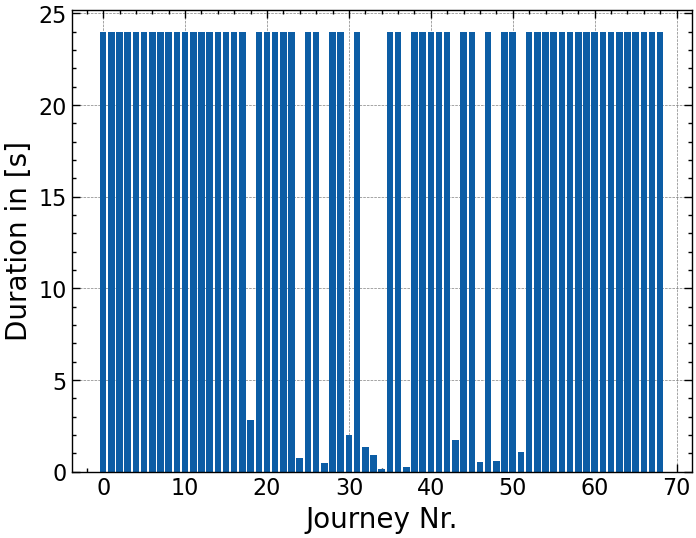

In [22]:
journey_list = X.columns
length = []
for jrn in journey_list:
    if X[jrn].isna().value_counts().shape == (1,):
        x = len(X[jrn])
    else: 
        x = X[jrn].isna().value_counts().iloc[1]
    length.append(x*(1/20625))
    
x = np.linspace(0,len(journey_list)-1,len(journey_list))
plt.bar(x,length)
plt.xlabel('Journey Nr.', fontsize=20)
plt.ylabel('Duration in [s]', fontsize=20)
#plt.savefig('pictures/Duration_shortened.png', dpi=200)

In [114]:
nan = []
journey_list = X.columns
for jrn in journey_list:
    if X[jrn].isna().value_counts().shape == (1,):
        nans = 0
    else: 
        nans = X[jrn].isna().value_counts().iloc[0]
    nan.append(nans)

nan

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 436626,
 0,
 0,
 0,
 0,
 0,
 480189,
 0,
 0,
 485788,
 0,
 0,
 453741,
 0,
 466795,
 476818,
 492561,
 0,
 0,
 489499,
 0,
 0,
 0,
 0,
 0,
 459982,
 0,
 0,
 484654,
 0,
 482745,
 0,
 0,
 472989,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [47]:
pd.set_option('display.max_columns', None)
X.head(500)

,journey_00_0,journey_00_1,journey_00_2,journey_00_3,journey_00_4,journey_00_5,journey_00_6,journey_00_7,journey_00_8,journey_01_0,journey_02_0,journey_02_1,journey_02_2,journey_02_3,journey_03_0,journey_03_1,journey_03_2,journey_04_0,journey_05_0,journey_06,journey_07_0,journey_07_1,journey_08,journey_09,journey_10_0,journey_10_1,journey_10_2,journey_11_0,journey_11_1,journey_11_2,journey_12_0,journey_12_1,journey_13_0,journey_14,journey_15_0,journey_15_1,journey_15_2,journey_16,journey_17,journey_18,journey_19,journey_20_0,journey_20_1,journey_20_2,journey_21,journey_22,journey_23,journey_24_0,journey_25,journey_26_0,journey_27,journey_28,journey_29_0,journey_30,journey_31,journey_32_0,journey_32_1,journey_32_2,journey_33_0,journey_33_1,journey_34,journey_35_0,journey_35_1,journey_35_2,journey_36_0,journey_36_1,journey_36_2,journey_37_0,journey_38
0,-0.221005,2.869321,2.068632,1.202845,0.981724,-0.232926,4.334543,0.337643,0.845334,0.487706,0.739331,-3.119310,-2.063606,-1.854522,0.862865,-14.341928,-1.456924,0.098757,0.097705,0.102497,0.220771,0.964310,0.198332,0.945493,0.246833,-0.325021,3.267854,NaN,0.411506,2.029129,NaN,0.000584,-15.018500,NaN,NaN,-0.128910,-0.936728,NaN,0.485953,0.441892,0.106353,0.146674,0.154388,0.203357,0.258871,0.269974,NaN,0.062643,NaN,0.438971,0.374224,NaN,0.157894,0.444113,0.432543,0.366159,0.222057,-2.275962,0.317073,2.583335,1.974082,0.517392,5.985709,-1.047756,-0.790521,5.271388,-0.275584,-0.626550,0.179048
1,-0.213992,2.848050,1.932827,1.423265,0.580619,-0.211772,2.641304,0.433361,0.892083,0.512483,0.824297,-2.459451,2.089318,-2.469151,0.904238,-14.104445,-1.198404,0.082628,0.130896,0.081577,0.232224,1.270163,0.231640,0.902835,0.200085,-0.324436,3.258387,NaN,0.513885,1.977121,NaN,-0.149713,-8.594288,NaN,NaN,0.000117,-0.982892,NaN,0.419102,0.410921,0.282129,0.100393,0.182203,0.278272,0.244730,0.196462,NaN,0.188982,NaN,0.481278,0.375626,NaN,0.269974,0.414661,0.503016,0.313567,0.520547,-2.155701,0.348512,2.246861,1.839680,0.420388,7.385015,-0.142116,-0.546142,2.916303,1.586419,-0.588917,0.153453
2,-0.170282,2.745320,1.771894,1.960058,0.402390,-0.420505,1.615987,0.358095,0.953908,0.515639,0.918262,-4.590843,3.123985,-2.356955,0.931936,-16.237005,-1.523541,0.053527,0.152050,0.120378,0.265299,3.073262,0.201838,0.479759,0.195643,-0.322917,3.315654,NaN,0.626784,1.984367,NaN,-0.130896,9.670912,NaN,NaN,-0.008181,-0.997969,NaN,0.339279,0.346525,0.370484,0.117106,0.251041,0.262144,0.191436,-0.024076,NaN,0.229887,NaN,0.789002,0.394793,NaN,-0.126338,0.289258,0.396663,0.303516,0.997384,-2.122743,0.440490,2.717037,1.705511,0.441191,2.467983,-1.846809,-0.286570,0.700413,3.361351,-0.927378,0.069539
3,-0.178230,2.798613,1.561408,2.495448,0.531767,-0.648872,2.900759,0.144103,0.943740,0.491797,0.945610,-5.913949,0.156725,-1.891103,0.924106,-16.892424,-1.738586,0.012622,0.141181,0.162919,0.286804,3.667322,0.143986,0.399000,0.199968,-0.393274,3.322550,NaN,0.644665,2.001664,NaN,0.038801,14.150142,NaN,NaN,-0.098406,-1.021226,NaN,0.387430,0.377262,0.273597,0.177061,0.291478,0.139077,0.205461,-0.044996,NaN,0.094549,NaN,0.810273,0.321865,NaN,-0.575594,0.287622,0.191904,0.315087,1.275306,-2.070735,0.524287,3.473431,1.632466,0.573724,-1.578588,-2.997179,-0.203941,2.563584,1.659931,-1.125359,0.055280
4,-0.176009,2.842908,1.447692,2.769746,0.465968,-0.793677,3.836903,0.137909,0.869994,0.473682,0.927028,-3.911584,-1.513374,-2.046660,0.889862,-14.711010,-1.229726,-0.000467,0.130429,0.167477,0.304568,2.590348,0.145622,0.962790,0.209551,-0.488407,3.108791,NaN,0.531533,1.932710,NaN,-0.025361,-1.452834,NaN,NaN,-0.038100,-1.083168,NaN,0.445632,0.387547,0.190034,0.215979,0.283297,-0.045113,0.236665,0.201253,NaN,-0.042191,NaN,0.446100,0.336357,NaN,-0.217265,0.392105,0.119794,0.286804,1.414617,-1.714159,0.514704,3.659374,1.609442,0.666286,-3.778701,-3.033409,-0.106587,5.122610,0.044645,-0.869994,0.057618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# Integrate & Apply Quad Car Modell 

In [12]:
# Import Quad Car Function and initialize parameters
def quad_car(f, m_s, m_us, k_s, k_us, c):
    """
    This function models the impulse response of a 
    single degree-of freedom oscillator in the frequency domain.
    Formula is taken form Schenkendorf et al. (2016; "Improved Railway Track 
    Irregularities Classification by a Model Inversion Approach"; Formulas (4-8))
    """
    #initialisation:
    w = 2*np.pi*f
    A = np.empty((4,4))
    B = np.empty((4,1))
    C = np.empty((1,4))
    G = np.empty((len(f)),dtype=complex)
    #
    A[0:4,0] =[-c/m_s, c/m_us, 1, 0]
    A[0:4,1] =[c/m_s, -c/m_us, 0, 1]
    A[0:4,2] =[-k_s/m_s, k_s/m_us, 0, 0]
    A[0:4,3] =[k_s/m_s, -(k_s+k_us)/m_us, 0, 0]
    
    B[0:4,0] = [0, k_us/m_us, 0, 0]
    
    C[0,0:4] = [-c/m_s, c/m_s, -k_s/m_s, k_s/m_s]
    D = 0
#    C[0,0:4] = [c/m_us, -c/m_us, k_s/m_us, -(k_s+k_us)/m_us]
#    D = k_us/m_us
    for wc, ww in enumerate(w):
        G[wc] = (np.matmul(np.matmul(C,np.linalg.inv(1j*ww*np.identity(4) - A)),B)+D)[0]
    return G

fs = 20625

#sprung mass (gefederte masse)
m_s = 9875 # in [kg]
#unsprung mass (ungefederte masse)
m_us = 1100 # in [kg]
# (spring) constants
k_s = 2.13*10**6 # in [N/m]
k_us = 1.42*10**8 # in [N/m]
c = 1.2*10**4 # in [N-s/m]

# Integration acceleration to position
from scipy.integrate import cumtrapz

# Mean -> 0 before integration!
def zero_mean(a):
    return a - np.mean(a)

In [ ]:
journey_list = a_filt_.columns
for jrn in journey_list:
    a_filt_[jrn] = a_filt_[jrn].apply(zero_mean)

In [ ]:
# # create vector with valid data and timepoints
# filt = (a_filt_['journey_00'].isna() == False)
# x = a_filt_['journey_00'].loc[filt].to_numpy()
# print('acc mean:')
# print(x.mean())
# x = x - np.mean(x)
# print(x.mean())
# t = np.linspace(0,len(x)/20625, len(x))

# v_hand=[]
# for acc in x:
#     v_hand.append(acc*delta_t)

# pos_hand=[]
# for vel in v_hand:
#     pos_hand.append(vel*delta_t)

# # define sample rate in Hz 
# fs = 20625 
# delta_t = 1/fs

# # double Integrate the accaleration data to obtain the position difference
# # vel = cumtrapz(x, t, initial=0)
# # print('vel mean:')
# # print(vel.mean())
# # vel = vel - np.mean(vel)
# # print(vel.mean())

# # pos = cumtrapz(vel, t, initial=0)
# # print('pos mean:')
# # print(pos.mean())
# # pos = pos - np.mean(pos)
# # print(pos.mean())



In [ ]:
fs = 20625
#sprung mass (gefederte masse)
m_s = 9875 # in [kg]
#unsprung mass (ungefederte masse)
m_us = 1100 # in [kg]
# (spring) constants
k_s = 2.13e6 # in [N/m]
k_us = 1.42e8 # in [N/m]
c = 1.2e4 # in [N-s/m]

#create quad car transfer function
x_f = fft(z_pos)
f = fftfreq(N, 0.01)
G_f = quad_car(f, m_s, m_us, k_s, k_us, c)

# Calculate output in freq. domain
y_f = x_f*G_f

plt.plot(f[:N//2], np.abs(y_f)[:N//2])
plt.plot(f[:N//2], np.abs(x_f)[:N//2])

In [17]:
def acc_to_pos(a_filt_, fs):

    # Function computes position for input to quad car model from acc data
    # input as pandas dfs
    vel = pd.DataFrame()
    pos = pd.DataFrame()
    delta_t = 1/fs
    
    
    # create list which contains strings for each journey
    journey_list = a_filt_.columns

    #loop going through all jounreys
    for jrn in journey_list:
        
        # create vector with valid data and timepoints
        filt = (a_filt_[jrn].isna() == False)
        x = a_filt_[jrn].loc[filt].to_numpy()
        
        v_hand=[]
        for acc in x:
            v_hand.append(acc*delta_t)
        pos_hand=[]
        for vel in v_hand:
            pos_hand.append(vel*delta_t)

        vel[jrn]=pd.Series(v_hand)
        pos[jrn]=pd.Series(pos_hand)
        


    return vel, pos

#vel,pos = acc_to_pos(a_filt_, 20625)

In [19]:
ptest = pd.DataFrame()
vtest = pd.DataFrame()

In [ ]:
def integ_acc(acc):
    return acc*(1/20625)

a_filt_['journey_00'].apply(integ_acc)